# MIT 18.05: Selected Problems & Exercises
Ravi Dayabhai

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import geom, norm
from scipy.special import comb

import matplotlib.pyplot as plt

## Counting

Assume the traditional "Birthday problem" set up. Calculate the probability that some trio in a group of $n$ people have the same birthday.

In [3]:
# Define simulation
def birthday_triplet_sim(n: int, trials: int) -> float:
    trial_ct = 0
    success_ct = 0
    for _ in range(trials):
        trial_ct += 1
        group = np.random.randint(1, 365 + 1, n)
        (unique, counts) = np.unique(group, return_counts=True)
        if any(filter(lambda x: x >= 3, counts)):
            success_ct += 1
    return success_ct / trial_ct

What is minimum $n$ such that the probability of this event is at least $\frac{1}{2}$?

In [4]:
# Run 10k trials
trials = 10_000
experiments = 10
ns = [87, 88]

for n in ns:
    experiment_results = [birthday_triplet_sim(n, trials) for _ in range(experiments)]
    print(f"Average probability, {experiments} experiments: {np.mean(experiment_results)}")

Average probability, 10 experiments: 0.49822
Average probability, 10 experiments: 0.50907


## Distributions

### Geometric

Suppose that the inhabitants of an island plan their families by having babies until the first girl is born. Assume the probability of having a girl with each pregnancy is 0.5 independent of other pregnancies, that all babies survive and there are no multiple births. What is the probability that a family has $k$ boys?

In [5]:
# Geometric PDF (up to a point)
p = 0.5
loc = -1
for k in range(20 + 1):
    print(f"The probability of having {k} boys:", f"{geom.pmf(k, p, loc):.5f}")

The probability of having 0 boys: 0.50000
The probability of having 1 boys: 0.25000
The probability of having 2 boys: 0.12500
The probability of having 3 boys: 0.06250
The probability of having 4 boys: 0.03125
The probability of having 5 boys: 0.01562
The probability of having 6 boys: 0.00781
The probability of having 7 boys: 0.00391
The probability of having 8 boys: 0.00195
The probability of having 9 boys: 0.00098
The probability of having 10 boys: 0.00049
The probability of having 11 boys: 0.00024
The probability of having 12 boys: 0.00012
The probability of having 13 boys: 0.00006
The probability of having 14 boys: 0.00003
The probability of having 15 boys: 0.00002
The probability of having 16 boys: 0.00001
The probability of having 17 boys: 0.00000
The probability of having 18 boys: 0.00000
The probability of having 19 boys: 0.00000
The probability of having 20 boys: 0.00000


What about the ratio of boys to girls on the island?

In [6]:
# Expectation of Geometric distribution
geom.mean(p, loc)

1.0

### Runs

A run is a sequence of all $1$s or $0$s. For this problem, consider sequence of 50 Bernoulli random variables where $p = 0.5$.

In [7]:
def longest_runs_sim(n: int = 50) -> int:
    # Random sequence where each n_i is element of {0, 1}
    seq = np.random.randint(0, 1+1, n)

    longest_runs = {1: None, 0: None}
    for i, outcome in enumerate([~seq, seq]):
        runs = \
            np.diff( # Diff of indices counts runs
                np.where( 
                    np.concatenate( # Checks if next value is different; if yes, then 1
                        # Note: Concatenation deals with edge cases
                        ([outcome[0]], outcome[:-1] != outcome[1:], [True])
                    )
                )[0] # Returns indices for whenever value switches
            )[::2] # Only return the diffs for the 1s
        longest_runs[i] = runs.max()

    # Longest runs (0s or 1s) and sequence
    return max(longest_runs.values()), seq

What's the average length of a "longest run"?

In [8]:
# Calculate average longest run
trials = 10_000
results = []
for _ in range(trials):
    results.append(longest_runs_sim(50)[0])

# Longest runs average
sum(results) / len(results)

5.5159

If $Y$ the the length of the "longest run" in a series of $n=50$ fair coin flips, what is $P(Y \geq 8)$?

In [9]:
event_ct = 0
for _ in range(trials):
    if longest_runs_sim(50)[0] >= 8:
        event_ct += 1

# Estimate probability of a longest run in 50 flips >= 8
event_ct / trials

0.1239

## Continuous Distributions

### Standard Normal

Below, we practice computing probabilities using SciPy's standard normal class.

In [10]:
z_1 = 1.5
z_2 = -1
z_3 = 1

print(f"P(Z < {z_1}) = {round(norm.cdf(z_1), 3)}")
print(f"P({z_2} < Z < {z_3}) = {round(norm.cdf(z_3) - norm.cdf(z_2), 3)}")

P(Z < 1.5) = 0.933
P(-1 < Z < 1) = 0.683


The length of human gestation is well-approximated by a normal distribution with mean μ = 280 days and standard deviation σ = 8.5 days. Graph the PDF and CDF a random variable distributed according to this distribution.

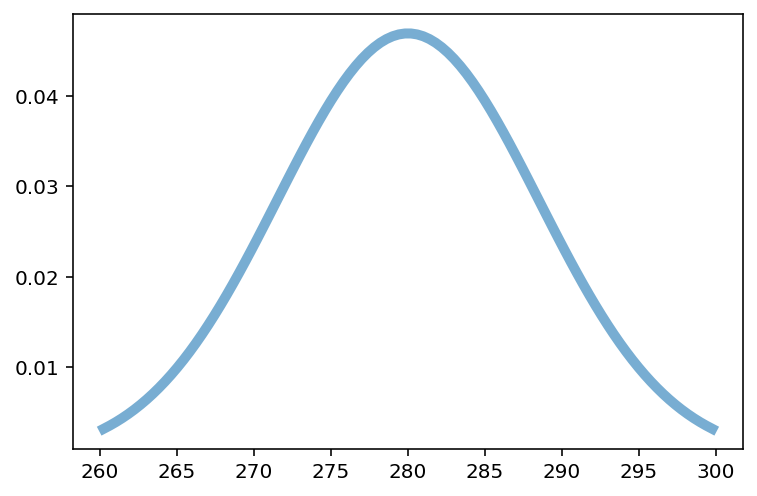

In [11]:
mu = 280
sigma = 8.5

z = np.linspace(norm.ppf(0.01), norm.ppf(.99), 100)
x = sigma * z + mu
plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), lw=5, alpha=0.6, label='norm pdf')
plt.show()

The probability of giving birth μ-7 days or earlier assuming the above distribution is calculated as $P(X < \mu - 7)$.

In [12]:
norm.cdf(mu-7, loc=mu, scale=sigma)

0.2051034993461297

### Binomial $\rightarrow$ Normal

Let's explore how, in the limiting case under special conditions, the Binomial approximates the Normal.

#### Claim

Because $Y \sim \text{Bin}(n, p)$ can be expressed as $\sum_{i=1}^{n} X_{i}$ for $X_{i} \stackrel{\text{i.i.d.}}{\sim} \text{Bern}(p)$), we can use the Central Limit Theorem (CLT) provided that $n$ is sufficiently large. Specifically, the CLT tells us:

$$
\begin{align}
Z  &= \frac{Y - \mu_{Y}}{\sigma_{Y}} \stackrel{d}{\rightarrow} \mathcal{N}(0,1)\\
Z  &= \frac{Y - np}{\sqrt{npq}}\\
\end{align}
$$

#### Justification

Notice that getting from the above to a more familiar incarnation of the CLT for a Bernoulli random variable $X$ is just a matter of transforming $Y$; said another way, $\frac{Y}{n} = \bar{X_{n}}$ is a sampled mean and we know that the sampling distribution of the sample mean is Normal.

$$
\begin{align}
\frac{Y}{n} = \bar{X_{n}} \implies Z &= \frac{\frac{Y}{n} - \mu_{\bar{X_{n}}}}{\sigma_{\bar{X_{n}}}} \stackrel{d}{\rightarrow} \mathcal{N}(0,1)\\
Z  &= \sqrt{n}\frac{\bar{X_{n}} - p}{\sqrt{pq}} = \sqrt{n}\frac{\hat{p_{n}} - p}{\sqrt{pq}}\\
\end{align}
$$

So, to get from the bottom relationship to the top we can simply multiply the numerator and denominator on the right-hand side by $n$!

## Expectation & Variance (Univariate)

Suppose you are playing a game where you roll two dice. The payoff function can be described as:

$$
Y_{i, j} = ij - 10
$$

1. What's the expected payoff for this game? 
2. Is this a better game to play versus a game where you win \\$500 on rolling a 7 (this game sums the dice values) and lose \\$100 otherwise?

In [13]:
# Create two dice arrays
dice_1 = np.arange(1, 6+1)
dice_2 = dice_1.copy()

# Construct sample space, probability space, and outcomes
sample_space = np.array([np.tile(dice_1, len(dice_2)), 
                     np.repeat(dice_2, len(dice_1))])
rv_value = np.prod(sample_space, axis=0, keepdims=True) - 10
prob_distribution = np.full_like(rv_value, 1/sample_space.shape[1], dtype='float')

# Expected value of playing this dice game
expected_value = rv_value.dot(prob_distribution.transpose()).item(0)
expected_value

2.25

This is a better game than the alternative because the alternative's expected value is 0!